In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import time
import geopy.distance
from tqdm import tqdm
from sklearn.cluster import SpectralClustering

import sklearn.cluster
import ast
%matplotlib notebook
pd.set_option('display.max_colwidth', 10)


## loading scraped files

In [8]:
def events_to_venues(df_events):
    venues = df_events.venue
    venues = [ast.literal_eval(x) if pd.notnull(x) else dict() for x in list(venues)]
    df_venues = pd.DataFrame(venues, columns=venues[0].keys())
    return df_venues

In [9]:
GROUPS_CSV = "groups.csv"
EVENTS_CSV = "events.csv"
VENUES_CSV = "venues.csv"


df_groups = pd.read_csv(GROUPS_CSV)
df_events = pd.read_csv(EVENTS_CSV)
df_venues = pd.read_csv(VENUES_CSV)
df_old_events = pd.read_csv('_' + EVENTS_CSV)
df_old_venues = pd.read_csv('_' + VENUES_CSV)


Groups have events which have venues  
groups > events > venues

In [10]:
df_groups.head()

,Unnamed: 0,level_0,category,city,country,created,description,group_photo,id,index,...,members,name,organizer,rating,timezone,topics,urlname,utc_offset,visibility,who
0,0,0,{'name...,Sydney,AU,152386...,<p>I h...,NaN,28179783,NaN,...,17,Blockc...,{'memb...,0.0,Austra...,[{'url...,meetup...,36000000,public,Members
1,1,1,{'name...,Sydney,AU,152387...,<p>Dun...,{'high...,28180718,NaN,...,13,Dungeo...,{'memb...,0.0,Austra...,[{'url...,Dungeo...,36000000,public,Members
2,2,2,{'name...,Sydney,AU,152388...,<p>Cal...,NaN,28182084,NaN,...,17,Sydney...,{'memb...,0.0,Austra...,[{'url...,meetup...,36000000,public,Members
3,3,3,{'name...,Sydney,AU,152389...,<p>WE ...,{'high...,28182760,NaN,...,207,I want...,{'memb...,0.0,Austra...,[{'url...,englis...,36000000,public,Members
4,4,4,{'name...,Sydney,AU,152389...,<p>Wel...,NaN,28182948,NaN,...,152,Japane...,{'memb...,0.0,Austra...,[{'url...,Japane...,36000000,public,Members


In [11]:
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3752 entries, 0 to 3751
Data columns (total 24 columns):
Unnamed: 0     3752 non-null int64
level_0        3752 non-null int64
category       3751 non-null object
city           3752 non-null object
country        3752 non-null object
created        3752 non-null int64
description    3751 non-null object
group_photo    1860 non-null object
id             3752 non-null int64
index          400 non-null float64
join_mode      3752 non-null object
lat            3752 non-null float64
link           3752 non-null object
lon            3752 non-null float64
members        3752 non-null int64
name           3752 non-null object
organizer      3673 non-null object
rating         3752 non-null float64
timezone       3752 non-null object
topics         3752 non-null object
urlname        3752 non-null object
utc_offset     3752 non-null int64
visibility     3752 non-null object
who            3752 non-null object
dtypes: float64(4), int64(6), ob

In [150]:
df_groups

,Unnamed: 0,level_0,category,city,country,created,description,group_photo,id,index,...,members,name,organizer,rating,timezone,topics,urlname,utc_offset,visibility,who
0,0,0,{'name...,Sydney,AU,152386...,<p>I h...,NaN,28179783,NaN,...,17,Blockc...,{'memb...,0.00,Austra...,[{'url...,meetup...,36000000,public,Members
1,1,1,{'name...,Sydney,AU,152387...,<p>Dun...,{'high...,28180718,NaN,...,13,Dungeo...,{'memb...,0.00,Austra...,[{'url...,Dungeo...,36000000,public,Members
2,2,2,{'name...,Sydney,AU,152388...,<p>Cal...,NaN,28182084,NaN,...,17,Sydney...,{'memb...,0.00,Austra...,[{'url...,meetup...,36000000,public,Members
3,3,3,{'name...,Sydney,AU,152389...,<p>WE ...,{'high...,28182760,NaN,...,207,I want...,{'memb...,0.00,Austra...,[{'url...,englis...,36000000,public,Members
4,4,4,{'name...,Sydney,AU,152389...,<p>Wel...,NaN,28182948,NaN,...,152,Japane...,{'memb...,0.00,Austra...,[{'url...,Japane...,36000000,public,Members
5,5,5,{'name...,Sydney,AU,152392...,<p>I h...,NaN,28188414,NaN,...,27,Puppet...,{'memb...,0.00,Austra...,[{'url...,Puppet...,36000000,public,Members
6,6,6,{'name...,Sydney,AU,152392...,<p>So ...,NaN,28188525,NaN,...,15,Thank ...,{'memb...,0.00,Austra...,[{'url...,Thank-...,36000000,public,Members
7,7,7,{'name...,Sydney,AU,152393...,<p>Thi...,NaN,28189512,NaN,...,60,Soul C...,{'memb...,0.00,Austra...,[{'url...,Soul-C...,36000000,public,Bright...
8,8,8,{'name...,Sydney,AU,152394...,<p><sp...,NaN,28190127,NaN,...,400,North ...,{'memb...,4.50,Austra...,[{'url...,North-...,36000000,public,Members
9,9,9,{'name...,Sydney,AU,152394...,<p>Do ...,NaN,28190173,NaN,...,12,Sydney...,{'memb...,0.00,Austra...,[{'url...,Sydney...,36000000,public,Members


In [160]:
list(df_groups.category.apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else ""))

['tech',
 'games',
 'career/business',
 'language/ethnic identity',
 'language/ethnic identity',
 'fine arts/culture',
 'new age/spirituality',
 'health/wellbeing',
 'fitness',
 'new age/spirituality',
 'career/business',
 'new age/spirituality',
 'career/business',
 'language/ethnic identity',
 'sports/recreation',
 'pets/animals',
 'music',
 'socializing',
 'fine arts/culture',
 'career/business',
 'outdoors/adventure',
 'games',
 'writing',
 'health/wellbeing',
 'health/wellbeing',
 'fashion/beauty',
 'tech',
 'music',
 'career/business',
 'sports/recreation',
 'career/business',
 'outdoors/adventure',
 'health/wellbeing',
 'outdoors/adventure',
 'outdoors/adventure',
 'sports/recreation',
 'health/wellbeing',
 'religion/beliefs',
 'career/business',
 'health/wellbeing',
 'fine arts/culture',
 'fitness',
 'career/business',
 'health/wellbeing',
 'health/wellbeing',
 'socializing',
 'health/wellbeing',
 'parents/family',
 'photography',
 'book clubs',
 'LGBT',
 'LGBT',
 'career/busin

In [13]:
df_events[df_events.status=="past"]

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,rsvp_limit,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count
0,0,0,130698...,<p><a ...,NaN,https:...,NaN,{'join...,0,Enter ...,...,NaN,past,130743...,130753...,36000000,{'coun...,public,0,NaN,26
1,1,1,131044...,<p>Com...,NaN,https:...,NaN,{'join...,0,NaN,...,NaN,past,131063...,131063...,36000000,{'coun...,public,0,NaN,6
2,2,2,131341...,<p>Com...,NaN,https:...,NaN,{'join...,12,NaN,...,NaN,past,131425...,131451...,36000000,{'coun...,public,0,NaN,23
3,3,3,131634...,<p> </...,NaN,https:...,NaN,{'join...,0,NaN,...,NaN,past,131779...,131793...,39600000,{'coun...,public,0,NaN,13
4,4,4,131634...,<p><b>...,NaN,https:...,NaN,{'join...,40,If you...,...,NaN,past,131823...,132946...,39600000,{'coun...,public,0,NaN,57
5,5,5,132787...,<p>How...,NaN,https:...,NaN,{'join...,0,Doors ...,...,NaN,past,132946...,133709...,39600000,{'coun...,public,1,NaN,21
6,6,6,133818...,<p>Spe...,NaN,https:...,NaN,{'join...,0,NaN,...,NaN,past,133957...,133964...,36000000,{'coun...,public,0,NaN,35
7,7,7,134477...,<p>Its...,NaN,https:...,NaN,{'join...,25,NaN,...,NaN,past,134864...,135409...,36000000,{'coun...,public,0,NaN,62
8,8,8,135355...,<p>Com...,NaN,https:...,NaN,{'join...,42,NaN,...,NaN,past,135408...,136713...,39600000,{'coun...,public,0,NaN,60
9,9,9,136478...,<p>A M...,NaN,https:...,NaN,{'join...,0,NaN,...,NaN,past,136696...,136713...,36000000,{'coun...,public,0,NaN,18


In [ ]:
df_events.sort_values(by='yes_rsvp_count', axis=0, ascending=False)

In [ ]:
df_events.loc[15403].event_url

In [15]:
df_events.head()
df_events["time_timestamp"] = df_events.time.apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(x/1000.0)))
df_events["time_timestamp"]  = pd.to_datetime(df_events["time_timestamp"])


<IPython.core.display.Javascript object>


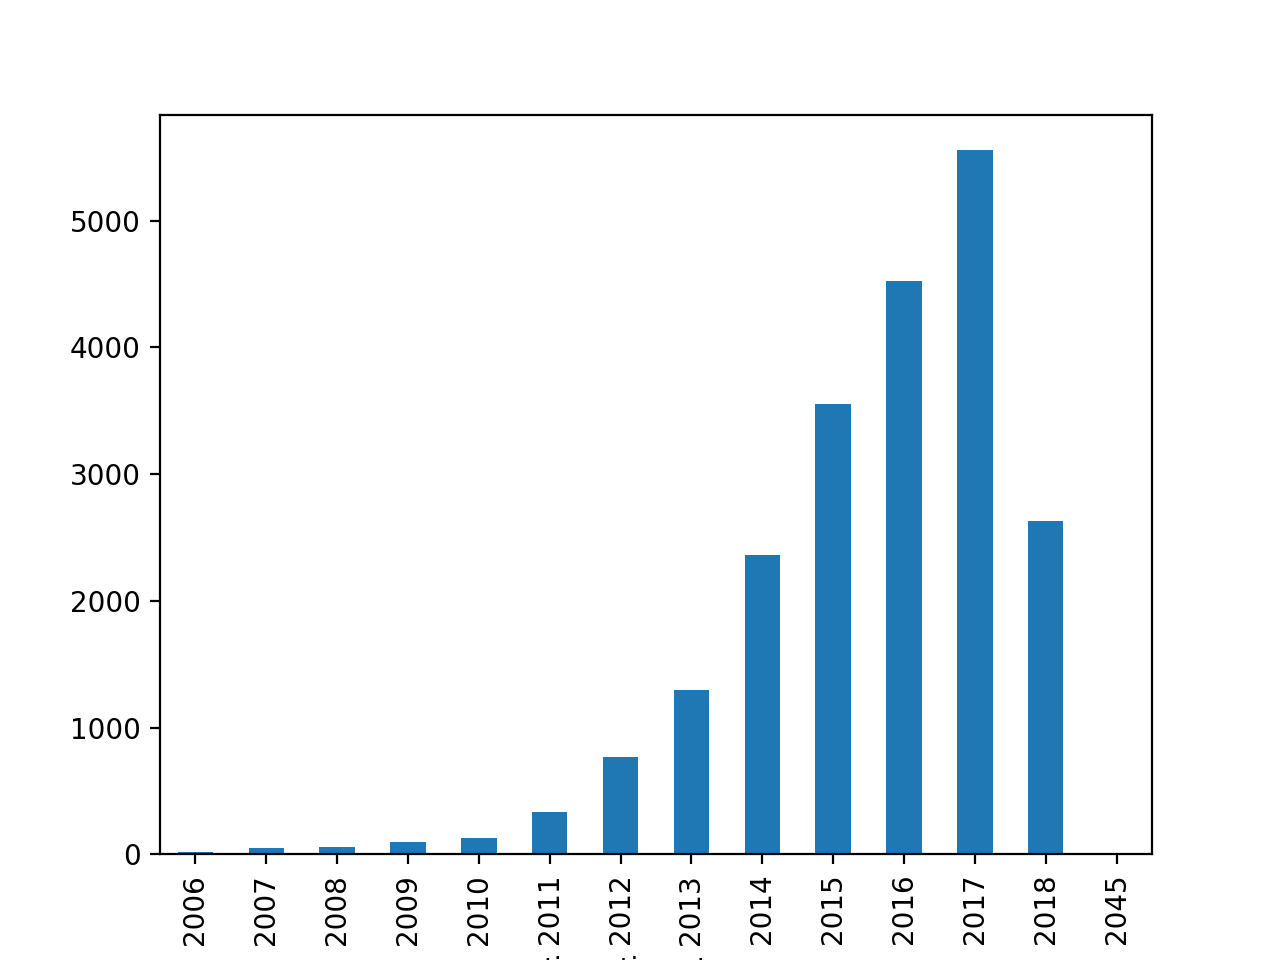

In [16]:
z = df_events.groupby(df_events.time_timestamp.dt.year).count()
# z.plot(x=z.time_timestamp, y=z.level_0)
z.time_timestamp.plot.bar()

In [17]:
df_events[df_events['time_timestamp'] > '2014-07-23 07:30:00']

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp
27,27,27,140532...,<p>The...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140722...,140808...,36000000,{'coun...,public,0,NaN,53,2014-08...
28,28,28,140628...,<p>Bui...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140834...,140835...,36000000,{'coun...,public,0,NaN,51,2014-08...
29,29,29,140686...,<p>And...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140843...,140844...,36000000,{'coun...,public,0,NaN,0,2014-08...
30,30,30,140808...,<p>The...,NaN,https:...,NaN,{'join...,0,NaN,...,past,140964...,140970...,36000000,{'coun...,public,0,NaN,52,2014-09...
31,31,31,140965...,<p>I a...,NaN,https:...,NaN,{'join...,0,NaN,...,past,141085...,141091...,36000000,{'coun...,public,0,NaN,34,2014-09...
32,32,32,141100...,<p>We'...,NaN,https:...,NaN,{'join...,0,NaN,...,past,141266...,141271...,39600000,{'coun...,public,0,NaN,55,2014-10...
33,33,33,141403...,<p>Our...,NaN,https:...,NaN,{'join...,0,If you...,...,past,141750...,141756...,39600000,{'coun...,public,0,NaN,88,2014-12...
34,34,34,142182...,<p>WE'...,NaN,https:...,NaN,{'join...,0,Follow...,...,past,142294...,142322...,39600000,{'coun...,public,0,NaN,66,2015-02...
35,35,35,142423...,<p>Our...,NaN,https:...,NaN,{'join...,0,NaN,...,past,142536...,142544...,39600000,{'coun...,public,0,NaN,69,2015-03...
36,36,36,142545...,<p>Wit...,NaN,https:...,NaN,{'join...,0,Walk p...,...,past,142839...,142847...,36000000,{'coun...,public,0,NaN,71,2015-04...


## So let's just look at 2017 data

In [51]:
events_df_2017 = df_events[df_events.time_timestamp.dt.year == 2017]
events_df_2011 = df_events[df_events.time_timestamp.dt.year == 2011]

In [61]:
events_df_2017.columns

Index(['Unnamed: 0', 'level_0', 'created', 'description', 'duration',
       'event_url', 'fee', 'group', 'headcount', 'how_to_find_us', 'id',
       'index', 'maybe_rsvp_count', 'name', 'photo_url', 'rating',
       'rsvp_limit', 'status', 'time', 'updated', 'utc_offset', 'venue',
       'visibility', 'waitlist_count', 'why', 'yes_rsvp_count',
       'time_timestamp'],
      dtype='object')

In [86]:
venues_df_2011 = events_to_venues(events_df_2011)
# venues_df_2011 = venues_df_2011[pd.notnull(venues_df_2011.lon)]  # remove all null rows.

In [102]:
venues_df_2017 = events_to_venues(events_df_2017)
venues_df_2017 = venues_df_2017.set_index(events_df_2017.index)
# venues_df_2017 = venues_df_2017[pd.notnull(venues_df_2017.lon)]  # remove all null rows.

In [118]:
venues_df_2017
venues_df_2017 = venues_df_2017[pd.notnull(venues_df_2017.lon)]  # remove all null rows.

In [20]:
events_df_2017 = events_df_2017.iloc[venues_df_2017.index]

## do this for 2017 data as well

In [96]:
venues_df_2011 = venues_df_2011.set_index(events_df_2011.index)
venues_df_2011 = venues_df_2011[pd.notnull(venues_df_2011.lon)]
# events_df_2011

In [105]:
events_df_2017

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp
62,62,62,147924...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148463...,148573...,39600000,{'coun...,public,0,NaN,99,2017-01...
63,63,63,148472...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148766...,148773...,39600000,{'coun...,public,0,NaN,130,2017-02...
64,64,64,148771...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149007...,149014...,39600000,{'coun...,public,0,NaN,118,2017-03...
65,65,65,149016...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149250...,149257...,36000000,{'coun...,public,0,NaN,113,2017-04...
66,66,66,149300...,<p>Wit...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149794...,149804...,36000000,{'coun...,public,0,NaN,133,2017-06...
67,67,67,149799...,<p>Tha...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150036...,150042...,36000000,{'coun...,public,0,NaN,126,2017-07...
68,68,68,150061...,<p>Cam...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150278...,150284...,36000000,{'coun...,public,0,NaN,110,2017-08...
69,69,69,150293...,<p>Sep...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150580...,150586...,36000000,{'coun...,public,0,NaN,122,2017-09...
70,70,70,150597...,<p><b>...,NaN,https:...,NaN,{'join...,0,We're ...,...,past,150822...,150854...,39600000,{'coun...,public,0,NaN,90,2017-10...
71,71,71,150396...,<p>PLE...,NaN,https:...,NaN,{'join...,0,NaN,...,past,150900...,150901...,39600000,{'coun...,public,0,NaN,1,2017-10...


# same number of rows as the number of venues

In [22]:
ex = df_venues.loc[1]

In [23]:
# example map
map_hooray = folium.Map(location=[ex.lat, ex.lon],
                    zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get
# remove nans
df_venues = df_venues[df_venues.lat.notnull()]

In [24]:
for ven in df_venues.iterrows():
    print(ven[1].lat)
# for ven in range(10):
#     print(df_venues.loc[ven,'lat'], df_venues.loc[ven,'lon'])
    folium.Marker( location=[ven[1]['lat'], ven[1].lon]).add_to( map_hooray )

    

-33.880444
-33.870399
-33.870399
-33.838039
-33.872955
-33.86687
-33.880463
-33.859634
-33.880463
-33.830921000000004
-33.880463
-33.880463
-33.867271
-33.857765
-33.867271
-33.880463
-33.867271
-33.867271
-33.867271
-33.867271
-33.867271
-33.867531
-33.880463
-33.867531
-33.799186999999996
-33.867531
-33.880463
-33.86687
-33.867531
-33.880463
-33.867531
-33.867531
-33.867531
-33.867531
-33.867531
-33.867531
-33.880463
-33.867531
-33.867531
-33.880463
-33.867531
-33.880463
-33.867531
-33.867531
-33.867531
-33.880463
-33.867531
-33.867531
-33.867531
-33.867531
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.868008
-33.880596000000004
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.867249
-33.868355
-33.867249
-33.867249
-33.868565000000004
-33.868355
-33.867249
-33.867249
-33.867249
-33.799896000000004
-33.868969
-33.797382
-33.89539
-33.868984000000005
-33.868984000000005
-33.880463
-33.868969
-33.880463
-33.880463
-33.8

-33.891664
-33.799881
-33.401374
-33.799881
-33.891664
-33.891664
-33.891664
-33.890575
-33.401374
-33.799881
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.871891
-33.871891
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832
-33.874832

-33.876846
-33.876644
-33.811539
-33.874889
-33.874889
-33.874889
-33.874889
-33.876846
-33.874889
-33.874889
-33.874889
-33.874889
-33.874889
-33.874889
-33.876233
-33.873611
-33.873611
-33.735240000000005
-33.873611
-33.876846
-33.873611
-33.735123
-33.735123
-33.873611
-33.873611
-33.873611
-33.922127
-33.922127
-33.922127
-33.922127
-33.922127
-33.922127
-33.922127
-33.867802000000005
-33.922127
-33.922127
-33.922127
43.166058
43.669715999999994
0.0
43.669715999999994
0.0
43.669715999999994
43.166058
0.0
43.669715999999994
0.0
-33.922127
43.669715999999994
0.0
0.0
43.669715999999994
0.0
0.0
-33.867160999999996
-33.859251
-33.867160999999996
-33.867160999999996
-33.867160999999996
-33.864994
-33.864994
-33.862999
-33.862999
-33.864994
-33.864994
-33.862999
-33.866279999999996
-33.864994
-33.867160999999996
-33.867160999999996
-33.868008
-33.868008
-33.88025
-33.873791
-33.86676
-33.873791
-33.88025
-33.88025
-33.867160999999996
-33.867160999999996
-33.863873
-33.858212
-33.866279999

-33.599537
-33.865913
-33.863544
-33.840396999999996
-33.86455
-33.862109999999994
-33.854229
-33.866758000000004
-33.86455
-33.764595
-33.867344
-33.866801
-33.870228000000004
-33.86455
-33.865346
0.0
-33.741577
-33.618317
-33.847012
-33.700127
-33.86455
-33.862109999999994
-33.726738
-33.726738
-33.86455
-33.814376
-33.86455
-33.764595
-33.726738
-33.863544
-33.931011
-33.863544
-33.86455
-33.847012
-33.700127
-33.86455
-33.847012
-33.86455
-33.871113
-33.726738
-33.86455
-33.764595
-33.770134000000006
-33.847012
-33.86455
-33.726738
-33.866801
-33.700127
-33.86455
-33.726738
-33.86455
-33.774632000000004
-33.86455
-33.726738
-33.847012
-33.86455
-33.847012
-33.86455
-33.764595
-33.726738
-33.86455
-33.817989000000004
-33.86455
-33.700127
-33.86455
-33.726738
-33.770134000000006
-33.761967
-33.726738
-33.86455
0.0
-33.847012
-33.86455
-33.764595
-33.770134000000006
-33.871179
-33.86455
-33.726738
-33.863544
-33.814376
-33.726738
-33.761967
-33.86455
-33.861713
-33.700127
-33.86455
-3

-33.87365
-33.83289
-33.880463
-33.834846
-33.87365
-33.859972
-33.880463
-33.87365
-33.864609
-33.87365
-33.864609
-33.822281
-33.87365
-33.863556
-33.880463
-33.87365
-33.859972
-33.880463
-33.87365
-33.880463
-33.867309999999996
-33.89373
0.0
-33.880463
-33.867309999999996
-33.880463
-33.867309999999996
-33.880463
-33.867309999999996
-33.880463
-33.871759999999995
-33.859972
-33.877959000000004
-33.880463
-33.867309999999996
-33.880463
-33.867309999999996
-33.880463
-33.880463
-33.880463
-33.867309999999996
-33.859972
-33.867309999999996
-33.880463
-33.867309999999996
-33.862784999999995
-33.867309999999996
-33.776993
-33.776993
-33.867309999999996
-33.880463
-33.859972
-33.867309999999996
-33.880463
-33.880463
-33.880463
-33.880463
-33.867309999999996
-33.86591
-33.776993
-33.776993
-33.867309999999996
-33.867139
-33.86591
-33.904308
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-33.951458
-33.867317
-33.867317
-33.872054999999996
-33.863476
-33.95417800000000

-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.82159
-33.884979
-33.884979
-33.88342
-33.884979
0.0
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
0.0
-33.884979
-33.884979
-33.919575
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.88342
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.88342
-33.884979
-33.884979
-33.884979
-33.88342
-33.884979
-33.884979
-33.88342
-33.884979
-33.884979
-33.884979
0.0
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884979
-33.884

-33.612511
-33.76511
-33.760422
-33.703835
-33.746265
-33.760422
-33.809967
-33.760422
-33.768829
-33.746265
-33.746887
-33.778545
-33.760422
-32.978722
-33.746265
-33.746887
-33.778545
-33.766731
-33.760422
-34.849998
-33.746265
-33.746887
-33.760422
-33.746265
-33.746887
-33.778545
-33.760422
-33.769386
-33.7691
-33.746265
-33.746887
-33.778545
-33.760422
-33.75526
-33.774651
-33.746265
-33.766731
-33.75652
-33.760422
-33.750401000000004
-33.403984
-33.40377
-33.746887
-33.671764
-33.868010999999996
-33.760422
-33.737590999999995
-33.724125
-33.879292
-34.295105
-33.760422
-33.724602000000004
-33.746887
-33.760422
-33.746887
-33.760422
-33.737590999999995
-33.746887
-33.760422
-33.746887
-33.814376
-33.760422
-33.722214
-33.746887
-33.770134000000006
-33.720406
-33.746887
-33.760422
-33.669163
-33.760422
-33.760422
-33.727657
-33.483536
-33.66222
-33.664004999999996
-33.813286
-33.746887
-33.760422
-33.72914
-33.729523
-33.760422
-33.729523
-33.75652
-33.729523
-33.402817
-33.752285


-33.869746
-33.86529
-33.86529
-33.865364
-33.879112
-33.867855
-33.86079
-33.874474
-33.874317
-33.864994
-33.880463
-33.874317
-33.878815
-33.878815
-33.878815
-33.878815
-33.875688000000004
-33.875688000000004
-33.878815
-33.875688000000004
-33.875688000000004
-33.875688000000004
-33.875688000000004
-33.875688000000004
-33.875688000000004
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.88047
-33.876911
-33.876911
-33.876911
-33.876911
-33.876911
-33.876911
-33.876911
-33.876911
-33.876911
-33.881691
-33.824589
-33.881691
-33.89503
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.894062
-33.817432000000004
-33.79678
-33.842831
-33.844846000000004
-33.886848
-33.817432000000004
-33.7

-33.805248
-33.842831
-33.844846000000004
-33.842831
-33.844846000000004
-33.842831
-33.844846000000004
-33.842831
-33.844846000000004
-33.844846000000004
-33.886848
-33.842831
-33.844846000000004
-33.842831
-33.844846000000004
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.912827
-33.912827
-33.842831
-33.844846000000004
-33.886848
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.842831
-33.844846000000004
-33.912827
-33.88857
-33.842831
-33.844846000000004
-33.912827
-33.888569
-33.842831
-33.844846000000004
-33.912827
-33.888569
-33.842831
-33.844846000000004
-33.886848
-33.912827
-33.888569
-33.842831
-33.844846000000004
-33.912827
-33.888569
-33.842831
-33.844846000000004
-3

-33.871243
-33.871243
-33.871243
-33.871243
-33.871243
-33.92099
-33.920956
-33.857948
-33.871243
-33.806816
-33.718564
-33.867484999999995
-33.59581
-33.918853999999996
-33.871243
-33.98032
-33.98032
-33.988636
-33.98032
-33.918853999999996
-33.98032
-33.945053
-33.98032
-33.98032
-33.712311
-33.914574
-33.879017
-33.896397
-33.920260999999996
-33.893799
-33.920260999999996
-33.987968
-35.60805
-34.033297999999995
-33.496727
-33.71262
-33.987968
-33.87365
-34.736959999999996
-33.920260999999996
-34.831173
-33.920260999999996
-33.890575
-33.87685
-33.861588
-33.88306
-33.88183
-33.861488
-33.872707
-33.819431
-33.918365
-33.918365
-33.080486
-33.889590999999996
-33.87685
-33.873058
-33.819431
-33.857883
-33.920260999999996
-33.86455
-33.866333000000004
-33.86455
-33.871179
-33.86455
-33.863544
-33.86455
-33.866333000000004
-33.86455
-33.866801
-33.86455
-33.862109999999994
-33.86455
-33.86455
-33.86455
-33.987968
-33.86455
-33.863544
-33.86455
-33.783833
-33.86455
-33.86455
-33.86455
-

-33.895590000000006
-33.882111
-33.812595
-33.86534
-33.884914
-33.868999
-33.891921999999994
-33.816887
-33.877712
-33.878176
-33.865803
-33.867484999999995
-33.869545
-33.877712
-33.867844
-33.88613
-33.895195
-33.863682
-33.876598
-33.875202
-33.813927
-33.876633
-33.924609999999994
-33.891594
-33.876598
-33.876633
-33.866257
-33.891087
-33.867139
-33.859982
-33.896099
-33.916615
-33.896599
-33.894501
-33.869545
-33.876598
-33.876709000000005
-33.811820000000004
-33.86882
-33.919187
-33.876709000000005
-33.898472
-33.898697
-33.898834
-33.867139
-33.891689
-33.876709000000005
-33.876709000000005
-33.752293
-33.876709000000005
-33.866146
-33.866347999999995
-33.87542
-33.8437
-33.876709000000005
-33.891689
-33.866347999999995
-33.94838
-33.91701
-33.876709000000005
-33.867484999999995
-33.604282
-33.869628999999996
-33.876709000000005
-33.821796
-33.94838
-33.875546
-33.882633
-33.881119
-33.752293
-33.876709000000005
-33.862877000000005
-33.957401000000004
-33.867484999999995
-33.89

-33.85533
-33.841156
-33.86448
-33.85533
-33.87022
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.85533
-33.86448
-33.85533
-33.87022
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.078156
-33.85533
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
12.867438
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.85533
-33.86448
-33.85533
-33.8553

-33.888584
-33.888584
-34.721195
-33.883247
-34.721195
-33.888584
-33.883579
-33.888482
-34.721195
-33.883514
-33.883514
-34.721195
-34.721195
-33.780338
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
0.0
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
0.0
-33.838454999999996
-25.585241
-33.972427
-33.972427
-33.972427
-33.972427
-33.972427
-33.838454999999996
-33.972427
-33.766987
-33.766987
-33.972427
-33.766987
-33.778313
-25.585241
-25.585241
-25.585241
-33.972427
-25.585241
-33.760334
-25.585241
-25.585241
-33.760334
-25.585241
-25.585241
-25.585241
-33.972427
-33.766987
-25.585241
-25.585241
-33.766987
-33.972427
-33.972427
-33.972427
-25.585241
-25.585241
-33.812275
-33.766987
-33.77748
-33.812275
-33.77748
-33.885715000000005
-33.77748
-33.885715000000005
-33.766987
-33.77748
-33.766987
-33.766987
-33.77748
-33.77748
-33.77748
-33.766987
-33.775681
-33.775681
-33.775681
-33.86

-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718
-33.888718

-33.871113
-33.895271
-33.889431
-33.919003000000004
-33.660294
-33.882736
-33.863663
-33.872456
-33.857414
44.385647
-33.878056
-33.85497
-33.896824
-33.869545
-33.869545
-33.8569
-33.868697999999995
-33.884555999999996
-33.8794
-33.8965
-33.884555999999996
-33.8099
-33.869578999999995
-33.883095000000004
-33.884426
-33.841865999999996
-33.870284999999996
-33.874446999999996
-33.878184999999995
-33.874446999999996
-33.874446999999996
-33.878796
-33.780853
-33.92561
-33.907246
-33.87717
-33.876667
-33.876667
-33.876667
-33.876667
-33.876667
-33.876667
-33.868008
-33.868008
-33.868008
-33.868008
-33.868008
-33.868008
-33.868008
-33.868008
-33.869820000000004
-33.88025
-37.818484999999995
-33.88025
-37.850491
-33.863898999999996
-33.88025
-33.88025
-33.863898999999996
-33.86681
-33.866619
-33.892262
-33.876621
-33.89216
-33.894515999999996
-33.894515999999996
-33.921295
-33.921295
-33.921295
-33.921295
-33.873791
-33.873791
-33.88364
-33.910629
-33.910629
-33.910629
-33.910629
-33.910629

-34.048813
-34.076923
-33.36996
-34.050594
-33.831676
0.0
-33.768562
-34.438541
-34.396217
-34.666084000000005
-34.20108
-33.268032
-34.06108
-34.045677000000005
-34.048813
-33.703159
-33.867484999999995
-36.50456
-33.73617
-33.75005
-34.045677000000005
-34.060966
-34.18766
-34.438541
-34.690075
-33.759876
-33.675251
-41.13114
-34.135253999999996
-35.312912
-33.718945
-34.064377
-33.703159
-34.946289
-33.268032
-33.675251
-36.349552
-34.701019
-33.239197
-33.867484999999995
-33.867484999999995
-32.830996999999996
-34.438541
-34.135253999999996
-33.761753000000006
-33.2963
-33.239197
-34.045677000000005
-34.050697
-33.86808
-33.86808
-33.86808
-33.86808
-33.86808
-33.874694
-33.86808
-33.86808
-33.87468
-33.86808
-33.86808
-33.86808
-33.873703000000006
-33.871902
-33.87468
-33.879902
-33.873703000000006
-33.86808
-33.857494
-33.86385
-33.884223999999996
-33.884223999999996
-33.884223999999996
-33.884223999999996
-33.884223999999996
-33.884223999999996
-33.884223999999996
-33.88422399999

-33.888988
-33.815895000000005
-33.867484999999995
-33.888988
-33.888988
-33.685435999999996
-33.799377
0.0
-33.888988
-33.697186
-33.888988
-33.888988
-33.888988
0.0
-33.877327
-33.877327
-33.649048
-33.908627
-33.886192
-33.970455
-33.862999
-33.87365
-33.880520000000004
-33.910469
-33.868008
-33.858208000000005
-33.880428
-33.851452
-33.871251
-33.861858000000005
-33.867139
-33.869801
-33.889454
-33.872341
-33.86603
-33.880602
-33.891476000000004
-33.867139
-33.871014
-33.883922999999996
-33.852306
-33.882751
-33.858779999999996
-33.877842
-33.918003000000006
-33.868008
-33.890743
-33.843319
-33.871303999999995
-33.868168
-33.860378000000004
-33.856970000000004
-33.878424
-33.910865
-33.875118
-33.857883
-33.86475
-33.874516
-33.874516
-33.886383
-33.869972
-36.840389
-37.816555
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.813469
-33.81346

In [25]:
map_hooray.save('overall.html')

we need to filter out some value to make sense of it all

## using spectral clustering let's see what we end up getting

1. We need to come up with a similarity matrix of all the points.
    - similarity based on common members?
    - similarity based on distance from each other (distance matrix can be converted into a similarity matrix `[np.exp(- dist_matrix ** 2 / (2. * delta ** 2))]`)
    - custom fitness function based on category, 
2. push it through the spectral custering code.

In [26]:
import os
os.getcwd()

'/Users/ishaanvarshney/Dropbox/18s2/9318/meetup'

## Let's create a distance matrix

In [97]:
venues_df_2011

,country,localized_country_name,city,address_1,name,lon,id,lat,repinned
0,au,Australia,Ultimo,Level ...,Fishbu...,151.20...,1984031.0,-33.880444,False
1,au,Australia,Sydney,Level ...,Sabre ...,151.20...,2540281.0,-33.870399,False
2,au,Australia,Sydney,Level ...,Sabre ...,151.20...,2540281.0,-33.870399,False
3,au,Australia,North ...,Level ...,IPscape,151.21...,3561212.0,-33.838039,False
4,au,Australia,Sydney,2 Park St,Citigr...,151.20...,3897352.0,-33.872955,False
78,au,Australia,Manly,East E...,Manly ...,151.28...,943787.0,-33.799896,False
83,au,Australia,Sydney,77 Yor...,Bar 77...,151.20...,1013031.0,-33.868969,False
84,au,Australia,Manly,7 Mark...,The Space,151.28...,1582000.0,-33.797382,False
130,au,Australia,Sydney,308-...,Boca ...,151.22...,1558696.0,-33.878155,False
131,au,Australia,Sydney,61 - 1...,Garden...,151.21...,1608807.0,-33.865601,False


In [106]:
def venues_to_dist_mat(venues_df_2017):
    cache_dict = {}
    coords = list(zip(venues_df_2017.lat, venues_df_2017.lon))
    counter = 0
    dist_mat = np.zeros((len(coords), len(coords)))
    for i in tqdm(range(len(coords))):
    # for i in tqdm(range(1)):
        for ind, coord in enumerate(coords[i+1:]):
            if coords[i] != coord:
    #                 from IPython.core.debugger import set_trace; set_trace()
                dist_mat[i][i+ind] = geopy.distance.distance(coords[i], coord).meters
    return dist_mat


In [68]:
# dist_mat_2011 = venues_to_dist_mat(venues_df_2011)
# dist_mat_2011 = venues_df_2017

100%|██████████| 182/182 [00:03<00:00, 49.10it/s]


In [ ]:
np.save('dist_mat.npy', dist_mat)

In [27]:
dist_mat = np.load('dist_mat.npy')


In [116]:
dist_mat.shape

(3607, 3607)

In [120]:
venues_df_2017.shape

(3607, 9)

In [114]:
delta = 0.05
z = np.exp( -dist_mat / 1000 ** 2 / (2. * delta ** 2))
z2 = np.exp( -dist_mat_2011 / 1000 ** 2 / (2. * delta ** 2))
 

In [324]:
x=sklearn.cluster.SpectralClustering(affinity='precomputed')

In [325]:
r = x.fit(z)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:678: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


In [328]:
dir(r)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_estimator_type',
 '_get_param_names',
 '_pairwise',
 'affinity',
 'affinity_matrix_',
 'assign_labels',
 'coef0',
 'degree',
 'eigen_solver',
 'eigen_tol',
 'fit',
 'fit_predict',
 'gamma',
 'get_params',
 'kernel_params',
 'labels_',
 'n_clusters',
 'n_init',
 'n_jobs',
 'n_neighbors',
 'random_state',
 'set_params']

## To classify new points we find the closest point to an existing "trained" point and classify whatever that is. Similar to 1nn.

In [72]:
z2.shape

(182, 182)

In [321]:
r.predict(z2) # based on previous data we have successfully predicted the what kind of tech it should be 

AttributeError: 'SpectralClustering' object has no attribute 'predict'

In [322]:
# try without pre-computing affinity matrix
x.fit(dist_mat)

AttributeError: 'numpy.float64' object has no attribute 'fit'

In [76]:
a = sklearn.cluster.spectral_clustering(z)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:678: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


In [173]:
len(z)

3607

In [121]:
# now that we know 
venues_df_2017['category'] = a

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [125]:
venues_df_2017

,country,localized_country_name,city,address_1,name,lon,id,lat,repinned,category
62,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
63,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
64,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
65,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
66,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
67,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
68,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
69,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1
70,au,Australia,Sydney,Level ...,Atlassian,151.20...,255047...,-33.868355,False,1
71,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1


In [ ]:
venues_df_2017

In [79]:
venues_df_2017.category.unique() # 8 groups by default -> could potentially tweak this

array([1, 3, 6, 7, 5, 4, 2, 0])

In [124]:
# TODO there are a lot of double ups here
events_df_2017 = events_df_2017.drop(['level_0'], axis=1).reset_index()  # this is what add 'level_0' column

In [81]:
events_df_2017

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp
62,62,62,147924...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148463...,148573...,39600000,{'coun...,public,0,NaN,99,2017-01...
63,63,63,148472...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148766...,148773...,39600000,{'coun...,public,0,NaN,130,2017-02...
64,64,64,148771...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149007...,149014...,39600000,{'coun...,public,0,NaN,118,2017-03...
65,65,65,149016...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149250...,149257...,36000000,{'coun...,public,0,NaN,113,2017-04...
66,66,66,149300...,<p>Wit...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149794...,149804...,36000000,{'coun...,public,0,NaN,133,2017-06...
67,67,67,149799...,<p>Tha...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150036...,150042...,36000000,{'coun...,public,0,NaN,126,2017-07...
68,68,68,150061...,<p>Cam...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150278...,150284...,36000000,{'coun...,public,0,NaN,110,2017-08...
69,69,69,150293...,<p>Sep...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150580...,150586...,36000000,{'coun...,public,0,NaN,122,2017-09...
70,70,70,150597...,<p><b>...,NaN,https:...,NaN,{'join...,0,We're ...,...,past,150822...,150854...,39600000,{'coun...,public,0,NaN,90,2017-10...
71,71,71,150396...,<p>PLE...,NaN,https:...,NaN,{'join...,0,NaN,...,past,150900...,150901...,39600000,{'coun...,public,0,NaN,1,2017-10...


In [ ]:
events_df_2017_all_coords

In [143]:
events_df_2017

,Unnamed: 0,level_0,created,description,duration,event_url,fee,group,headcount,how_to_find_us,...,status,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp
62,62,62,147924...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148463...,148573...,39600000,{'coun...,public,0,NaN,99,2017-01...
63,63,63,148472...,<p>We ...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,148766...,148773...,39600000,{'coun...,public,0,NaN,130,2017-02...
64,64,64,148771...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149007...,149014...,39600000,{'coun...,public,0,NaN,118,2017-03...
65,65,65,149016...,<p>Our...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149250...,149257...,36000000,{'coun...,public,0,NaN,113,2017-04...
66,66,66,149300...,<p>Wit...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,149794...,149804...,36000000,{'coun...,public,0,NaN,133,2017-06...
67,67,67,149799...,<p>Tha...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150036...,150042...,36000000,{'coun...,public,0,NaN,126,2017-07...
68,68,68,150061...,<p>Cam...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150278...,150284...,36000000,{'coun...,public,0,NaN,110,2017-08...
69,69,69,150293...,<p>Sep...,NaN,https:...,NaN,{'join...,0,Look f...,...,past,150580...,150586...,36000000,{'coun...,public,0,NaN,122,2017-09...
70,70,70,150597...,<p><b>...,NaN,https:...,NaN,{'join...,0,We're ...,...,past,150822...,150854...,39600000,{'coun...,public,0,NaN,90,2017-10...
71,71,71,150396...,<p>PLE...,NaN,https:...,NaN,{'join...,0,NaN,...,past,150900...,150901...,39600000,{'coun...,public,0,NaN,1,2017-10...


In [144]:
venues_df_2017['level_0'] = venues_df_2017.index

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [189]:
# events_df_2017_all_coords = venues_df_2017.join(events_df_2017, on='level_0')
venues_df_2017

,country,localized_country_name,city,address_1,name,lon,id,lat,repinned,category,level_0
62,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,62
63,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,63
64,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,64
65,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,65
66,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,66
67,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,67
68,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,68
69,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,69
70,au,Australia,Sydney,Level ...,Atlassian,151.20...,255047...,-33.868355,False,1,70
71,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,71


In [212]:
events_df_2017_ven = events_df_2017.loc[venues_df_2017.index]

In [213]:
events_df_2017_ven = pd.concat([events_df_2017_ven, venues_df_2017], axis=1)

In [216]:
# bring the group.id out and then join
events_df_2017_ven['group_id'] = list(events_df_2017_ven.group.apply(lambda x: ast.literal_eval(x)['id'] if pd.notnull(x) else ""))


In [219]:
df_groups.columns

Index(['Unnamed: 0', 'level_0', 'category', 'city', 'country', 'created',
       'description', 'group_photo', 'id', 'index', 'join_mode', 'lat', 'link',
       'lon', 'members', 'name', 'organizer', 'rating', 'timezone', 'topics',
       'urlname', 'utc_offset', 'visibility', 'who'],
      dtype='object')

In [256]:
df.shape

(3607, 64)

In [228]:
df = pd.merge(events_df_2017_ven, df_groups, left_on='group_id', right_on='id', how='inner')


In [237]:
df['short_cat'] = list(df.category_y.apply(lambda x: ast.literal_eval(x)['name'] if pd.notnull(x) else ""))

In [251]:
df.groupby(['short_cat']).count()

,Unnamed: 0_x,level_0_x,created_x,description_x,duration,event_url,fee,group,headcount,how_to_find_us,...,members,name_y,organizer,rating_y,timezone,topics,urlname,utc_offset_y,visibility_y,who
short_cat,,,,,,,,,,,,,,,,,,,,,
LGBT,22,22,22,22,0,22,0,22,22,0,...,22,22,22,22,22,22,22,22,22,22
career/business,155,155,155,153,40,155,14,155,155,53,...,155,155,155,155,155,155,155,155,155,155
cars/motorcycles,1,1,1,1,0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
community/environment,33,33,33,33,22,33,0,33,33,8,...,33,33,33,33,33,33,33,33,33,33
dancing,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
education/learning,1,1,1,1,0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
fine arts/culture,48,48,48,46,35,48,0,48,48,5,...,48,48,48,48,48,48,48,48,48,48
fitness,126,126,126,79,5,126,5,126,126,82,...,126,126,126,126,126,126,126,126,126,126
food/drink,153,153,153,141,18,153,0,153,153,0,...,153,153,153,153,153,153,153,153,153,153


In [255]:
df.groupby(['category_x', 'short_cat']).count()

Unnamed: 0_x  level_0_x  created_x  description_x  \
category_x short_cat                                                       
0          career/...         49            49         49         48       
           cars/mo...          1             1          1          1       
           communi...          2             2          2          2       
           fine ar...         15            15         15         14       
           food/drink          2             2          2          1       
           games              36            36         36         36       
           health/...         38            38         38         38       
           hobbies...         33            33         33         33       
           languag...         44            44         44         44       
           movemen...         18            18         18         18       
           music              12            12         12         12       
           new age...          3             3          3          3       
           outdoor...        113           113        113        113       
           parents...          1             1          1          1       
           photogr...          7             7          7          7       
           religio...          5             5          5          0       
           sociali...        108           108        108        108       
           sports/...        113           113        113        113       
           tech              112           112        112        112       
1          LGBT               22            22         22         22       
           career/...          6             6          6          6       
           educati...          1             1          1          1       
           food/drink        109           109        109        109       
           games              50            50         50         50       
           languag...        102           102        102        102       
           new age...          1             1          1          1       
           outdoor...          7             7          7          7       
           religio...          1             1          1          1       
           sociali...        156           156        156        156       
           tech               86            86         86         86       
...                          ...           ...        ...        ...       
5          movemen...          9             9          9          9       
           new age...          3             3          3          3       
           outdoor...         63            63         63         63       
           photogr...          4             4          4          4       
           sociali...        119           119        119        119       
           tech               53            53         53         53       
6          career/...         14            14         14         14       
           communi...          1             1          1          1       
           fitness            46            46         46          1       
           games              56            56         56         56       
           health/...          8             8          8          8       
           languag...         31            31         31         31       
           movies/...          3             3          3          3       
           new age...         45            45         45         45       
           outdoor...          6             6          6          6       
           sociali...         50            50         50         50       
7          career/...          5             5          5          5       
           communi...         19            19         19         19       
           dancing             1             1          1          0       
           fine ar...          8             8          8          7   

In [253]:
pd.pivot_table(df, values='id_x', index=['category_x', 'short_cat'], columns=['C'], aggfunc=np.sum)

KeyError: 'C'

In [ ]:
events_df_2017_ven.group_id

In [172]:
events_df_2017_all_coords
#.groupby('group_id').count()


,country,localized_country_name,city,address_1,name_x,lon,id_x,lat,repinned,category,...,time,updated,utc_offset,venue,visibility,waitlist_count,why,yes_rsvp_count,time_timestamp,group_id
0,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,148463...,148573...,39600000,{'coun...,public,0,NaN,99,2017-01...,1954971
1,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,148766...,148773...,39600000,{'coun...,public,0,NaN,130,2017-02...,1954971
2,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,149007...,149014...,39600000,{'coun...,public,0,NaN,118,2017-03...,1954971
3,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,149250...,149257...,36000000,{'coun...,public,0,NaN,113,2017-04...,1954971
4,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,149794...,149804...,36000000,{'coun...,public,0,NaN,133,2017-06...,1954971
5,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,150036...,150042...,36000000,{'coun...,public,0,NaN,126,2017-07...,1954971
6,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,150278...,150284...,36000000,{'coun...,public,0,NaN,110,2017-08...,1954971
7,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,150580...,150586...,36000000,{'coun...,public,0,NaN,122,2017-09...,1954971
8,au,Australia,Sydney,Level ...,Atlassian,151.20...,255047...,-33.868355,False,1,...,150822...,150854...,39600000,{'coun...,public,0,NaN,90,2017-10...,1954971
9,au,Australia,Sydney,Level ...,Atlassian,151.20...,243538...,-33.867249,False,1,...,150900...,150901...,39600000,{'coun...,public,0,NaN,1,2017-10...,1954971


In [259]:
from shapely.geometry import MultiPoint
points = MultiPoint([(0.0, 0.0), (1.0, 1.0)])
print(points.centroid) #True centroid, not necessarily an existing point
print(points.representative_point()) #A represenative point, not centroid,
                                    #that is guarnateed to be with the geometry.

POINT (0.5 0.5)
POINT (0 0)


In [295]:
def group_to_centroid_coords(group):
    a = MultiPoint(list(zip(df[df.category_x == group].lat_x, df[df.category_x == group].lon_x))).centroid.coords
    return list(a)[0]

In [ ]:
def cat_to_centroid_coords(group):
    a = MultiPoint(list(zip(df[df.category_x == group].lat_x, df[df.category_x == group].lon_x))).centroid.coords
    return list(a)[0]

In [277]:
print(list(points.centroid.coords)[0]) #True centroid, not necessarily an existing point
lat,lon = list(points.centroid.coords)[0]

(-33.68911344803378, 150.34314424719102)


In [294]:
group_to_centroid_coords(0)

(-33.68911344803378, 150.34314424719102)

In [293]:
map_hooray = folium.Map(location=[lat, lon],
                    zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get
# remove nans
for group in df.category_x.unique():
    lat, lon = group_to_centroid_coords(group)
    folium.Marker([lat, lon], popup=str(group)).add_to(map_hooray)

map_hooray

In [298]:
df[df.short_cat=='tech'][['lat_x', 'lon_x']]

,lat_x,lon_x
0,-33.867249,151.20...
1,-33.867249,151.20...
2,-33.867249,151.20...
3,-33.867249,151.20...
4,-33.867249,151.20...
5,-33.867249,151.20...
6,-33.867249,151.20...
7,-33.867249,151.20...
8,-33.868355,151.20...
9,-33.867249,151.20...


In [308]:
map_hooray = folium.Map(location=[lat, lon],
                    zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get
# remove nans
for x, y in df[df.short_cat=='tech'][['lat_x', 'lon_x']].apply(tuple, axis=1):
    folium.Marker([x, y], popup=str(group)).add_to(map_hooray)
map_hooray

In [307]:
for x, y in df[df.short_cat=='tech'][['lat_x', 'lon_x']].apply(tuple, axis=1):
    folium.Marker([x, y], popup=str(group)).add_to(map_hooray)

-33.867249 151.20694
-33.867249 151.20694
-33.867249 151.20694
-33.867249 151.20694
-33.867249 151.20694
-33.867249 151.20694
-33.867249 151.20694
-33.867249 151.20694
-33.868355 151.206528
-33.867249 151.20694
-33.867249 151.20694
-33.868565 151.194443
-33.868008 151.205002
-33.868008 151.205002
-33.868008 151.205002
-33.880428 151.200394
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.874832 151.205429
-33.87891 151.203918
-33.872665 151.207642
-33.88025 151.20026
-33.872665 151.207642
-33.872665 151.207642
-33.872665 151.207642
-33.872665 151.207642
-33.872665 151.207642
-33.862831 151.209915
-33.881924 151.200897
-33.872665 151.207642
-33.874847 151.224136
-33.877327 151.206116
-33.876945 151.207596
-33.873791 151.209625
-33.86676 151.204361
-33.873791 151.209625
-33.88025 151.20026
-33.88025 151.20026
-33.867161 151.195663
-33.867161 151.195663
-33.86

In [319]:
a = MultiPoint(list(df[df.short_cat=='tech'][['lat_x', 'lon_x']].apply(tuple, axis=1)))
lat, lon = list(a.centroid.coords)[0]
map_hooray = folium.Map(location=[lat, lon],
                    zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get
# remove nans
folium.Marker([lat, lon], popup=str(group)).add_to(map_hooray)

map_hooray

In [320]:
map_hooray = folium.Map(location=[lat, lon],
                    zoom_start =10) # Uses lat then lon. The bigger the zoom number, the closer in you get
# remove nans
for x, y in df[df.short_cat=='outdoors/adventure'][['lat_x', 'lon_x']].apply(tuple, axis=1):
    folium.Marker([x, y], popup=str(group)).add_to(map_hooray)
map_hooray
